Examples from https://docs.obspy.org/tutorial/code_snippets/beamforming_fk_analysis.html

In [6]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

import obspy
from obspy.core.util import AttribDict
from obspy.imaging.cm import obspy_sequential
from obspy.signal.invsim import corn_freq_2_paz
from obspy.signal.array_analysis import array_processing


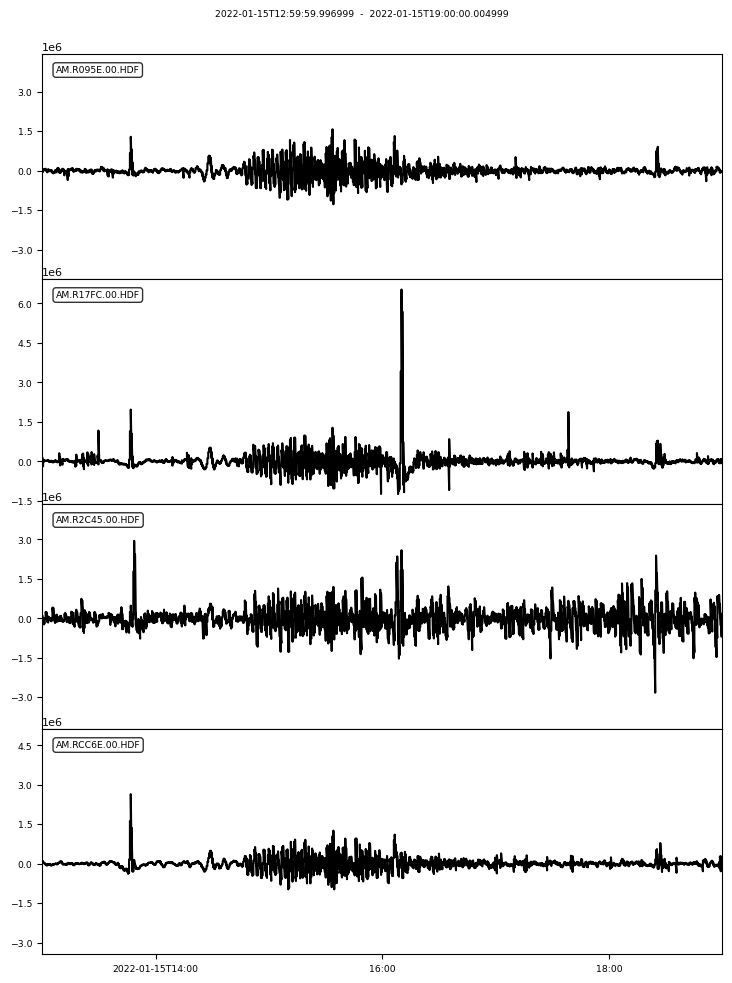

In [127]:
## LOAD DATA AND PREPARE FOR ARRAY PROCESSING

import os, sys
from obspy.geodetics import locations2degrees, degrees2kilometers
LIBpath = os.path.join( os.getenv('HOME'),'src','kitchensinkGT', 'LIB')
sys.path.append(LIBpath)
from libseisGT import clean_trace, mulplt

def attach_station_coordinates_from_inventory(inventory, st):
    """ attach_station_coordinates_from_inventory """
    for tr in st:
        for netw in inventory.networks:
            for sta in netw.stations:
                if tr.stats.station == sta.code and netw.code == tr.stats.network:
                    for cha in sta.channels:
                        if tr.stats.location == cha.location_code:
                            tr.stats.coordinates = AttribDict({
                                'latitude':cha.latitude,
                                'longitude':cha.longitude,
                                'elevation':cha.elevation})
                   
SEISAN_TOP = os.getenv('SEISAN_TOP')     
worfile = os.path.join(SEISAN_TOP, 'WOR', '2022-01-15-1300-00S.Tonga_038')
st = obspy.read(worfile)
st = st.select(channel='HDF')

wavbase = os.path.basename(worfile)
stationXmlFilePattern = os.path.join(SEISAN_TOP, 'CAL', '%s.xml' % wavbase)[0:-6] 
stationXmlFile = stationXmlFilePattern + '00.xml'
if os.path.exists(stationXmlFile):
    inv = obspy.read_inventory(stationXmlFile)
    for tr in st:
        # SCAFFOLD not removing response here, because it wasn't working anyway
        clean_trace(tr, taperFraction=0.05, filterType="bandpass", freq=[0.001, 10.0], \
                    corners=4, zerophase=True, inv=inv)

st.plot(equal_scale=False);
st.detrend('linear')
#mulplt(st)

# add coordinates
attach_station_coordinates_from_inventory(inv, st)

# compute distance
vlat = -(20 + 34/60 + 12 /3600) 
vlon = -(175 + 22/60 + 48/3600)
for tr in st:
    tr.stats.distance = degrees2kilometers(locations2degrees(vlat, vlon, tr.stats.coordinates.latitude, tr.stats.coordinates.longitude))

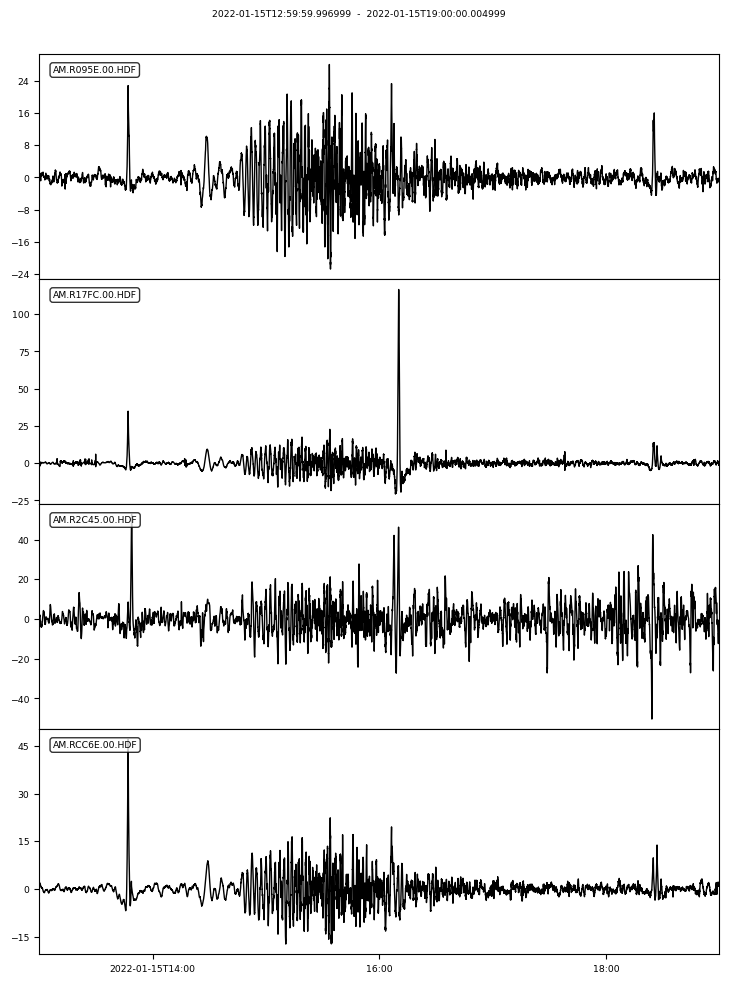

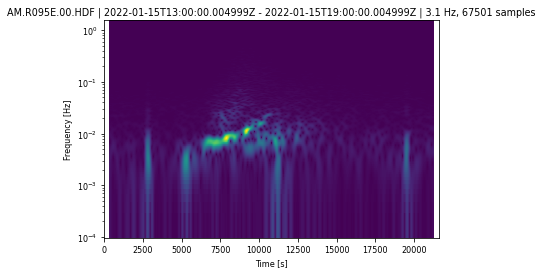

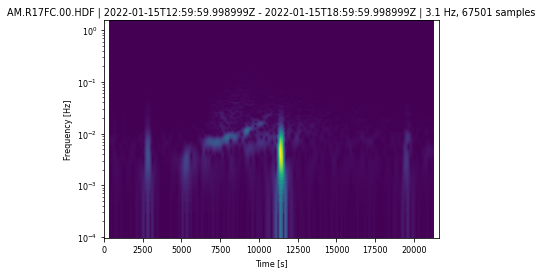

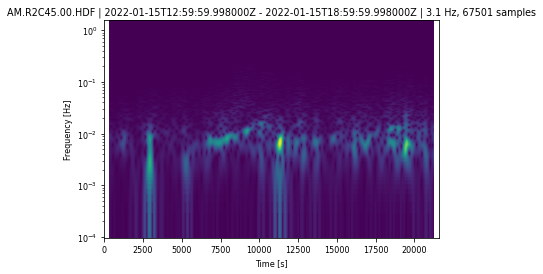

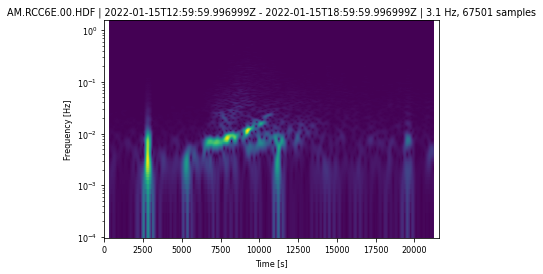

In [131]:
# For whatever reason, obspy Stream plot will not plot the corrected data (in Pascals). 
# Instead, it plots the signal in Counts still.
# So here I divide a copy of the signal by the sensitivity 56,000, so Stream plot will show Pascals.

# I've seen from spectrograms that there is only weak signal above 0.1 Hz
# So let's decimate to 1 Hz, to speed up
# To decimate by factor larger than 16, have to do in multiple stages

# decimate to speed up
st2 = st.copy()
st2.filter('lowpass', freq=1.0, corners=4)
for tr in st2:
    tr.decimate(8) # samplerate now 100/8 Hz
    tr.decimate(4) # samplerate now 100/32 Hz
    
#st.trim(starttime=obspy.UTCDateTime(2022,1,15,15,0,0), endtime=obspy.UTCDateTime(2022,1,15,16,0,0))
st3 = st2.copy()
for tr in st3:
    tr.data = tr.data / 56000
st3.plot(equal_scale=False)
for tr in st3:
    tr.spectrogram(log=True, wlen=500, per_lap=0.95)

2022-01-15T13:00:00.004999Z 2022-01-15T18:59:43.726999Z
4 Trace(s) in Stream:
AM.R095E.00.HDF | 2022-01-15T13:00:00.004999Z - 2022-01-15T18:59:43.724999Z | 100.0 Hz, 2158373 samples
AM.R17FC.00.HDF | 2022-01-15T13:00:00.008999Z - 2022-01-15T18:59:43.728999Z | 100.0 Hz, 2158373 samples
AM.R2C45.00.HDF | 2022-01-15T13:00:00.008000Z - 2022-01-15T18:59:43.728000Z | 100.0 Hz, 2158373 samples
AM.RCC6E.00.HDF | 2022-01-15T13:00:00.006999Z - 2022-01-15T18:59:43.726999Z | 100.0 Hz, 2158373 samples


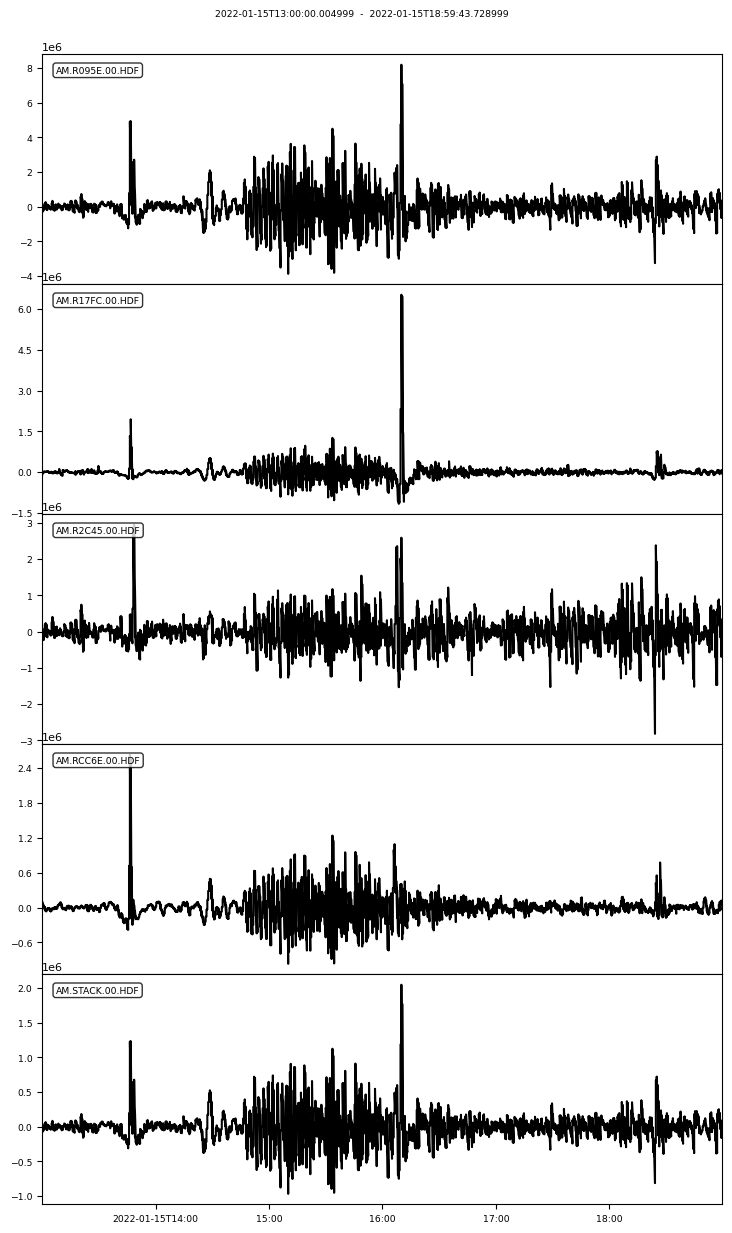

In [117]:
## Create stack

# compute travel time differences and sample delays
r = [tr.stats.distance for tr in st]
minr = min(r)
v = 0.5
for tr in st:
    tr.stats.tdiff = (tr.stats.distance - minr)/v
    tr.stats.sampledelay = np.round(tr.stats.tdiff/tr.stats.delta)    

# align waveforms for stack, removing sample delays
st_stack = st.copy()
max_st = st_stack[0].stats.starttime-86400
min_et = st_stack[0].stats.endtime
for tr in st_stack:
    tr.stats.starttime = tr.stats.starttime - tr.stats.sampledelay * tr.stats.delta
    #print(tr.stats)
    if tr.stats.starttime > max_st:
        max_st = tr.stats.starttime    
    if tr.stats.endtime < min_et:
        min_et = tr.stats.endtime
print(max_st, min_et)
st_stack.trim(starttime=max_st, endtime=min_et)
print(st_stack)

# create the stack
y = []
for tr in st_stack:
    if len(y)>0:
        y += tr.data
    else:
        y = tr.data
import matplotlib.pyplot as plt
newtr = st_stack[0].copy()
newtr.data = y / len(st_stack)
newtr.stats.station='STACK'
st_stack.append(newtr)
st_stack.plot(equal_scale=False);


[  0.00000000e+00   1.00000000e-02   2.00000000e-02 ...,   2.15999800e+04
   2.15999900e+04   2.16000000e+04]


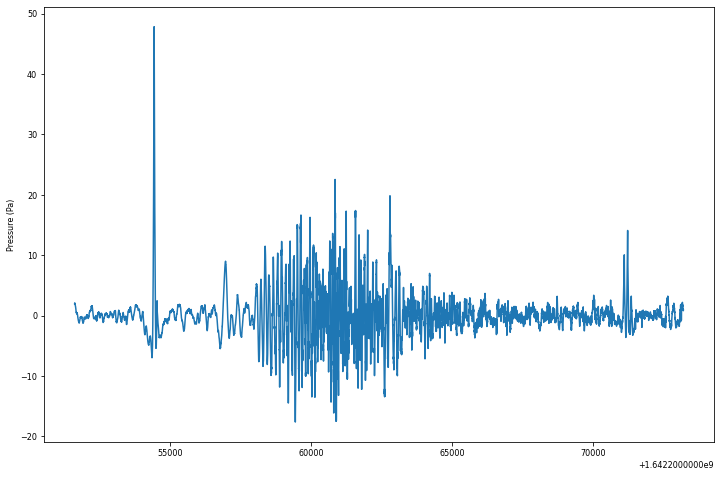

In [111]:
plt.figure(figsize=[12,8])
tr = st[-1]
seconds_offset = np.arange(len(tr.data))*tr.stats.delta
print(seconds_offset)
t = [tr.stats.starttime + i*tr.stats.delta for i in range(len(tr.data))]
plt.plot(t, st[-1].data)
#plt.xlabel('Minutes after 2022-01-15 13:00')
plt.ylabel('Pressure (Pa)')
plt.axis('tight')
xlocator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(xlocator)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(xlocator))

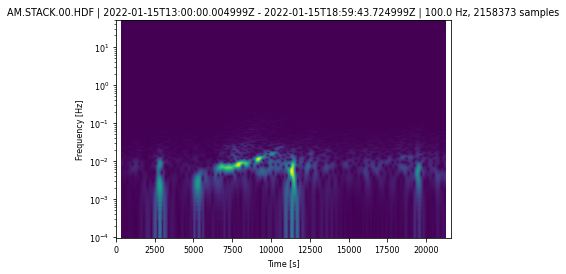

In [124]:
fh = plt.figure(figsize=(16,16))
tr = st_stack[4].copy()
tr.data = tr.data / 56000
tr.plot(handle=fh);

#tr.plot(type='dayplot')
tr.spectrogram(log=True, wlen=500, per_lap=0.95)

<Figure size 1152x1152 with 0 Axes>

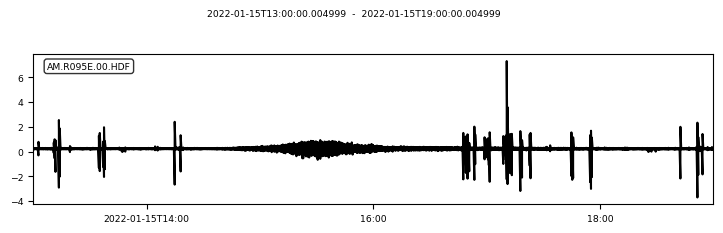

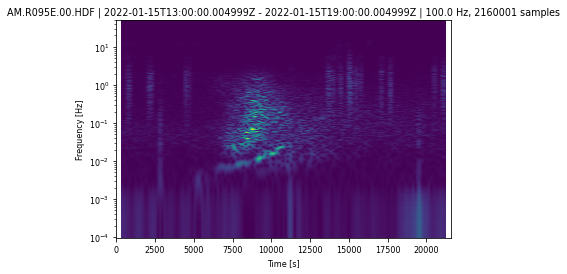

<Figure size 1152x1152 with 0 Axes>

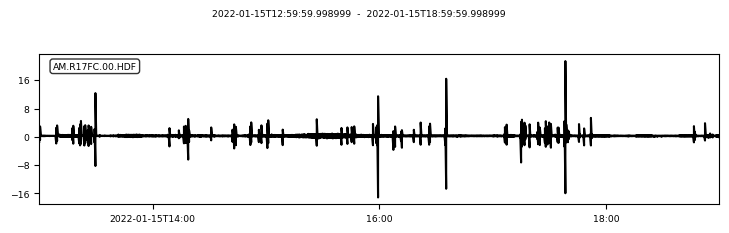

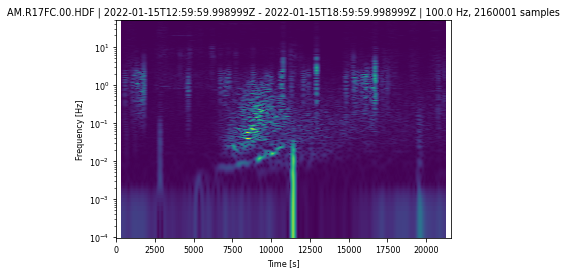

<Figure size 1152x1152 with 0 Axes>

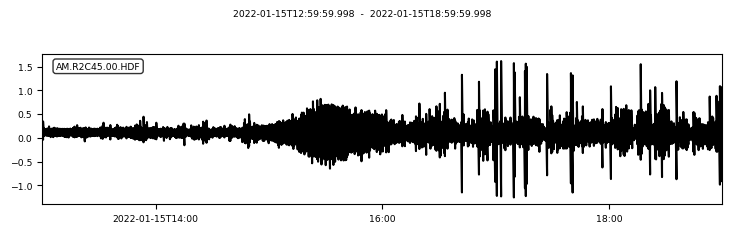

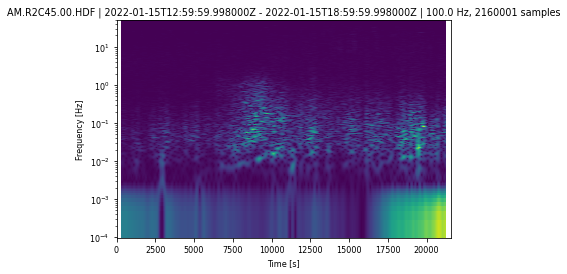

<Figure size 1152x1152 with 0 Axes>

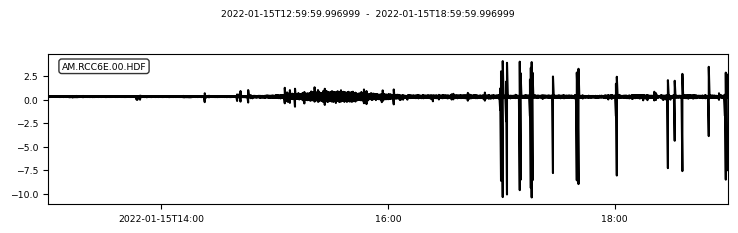

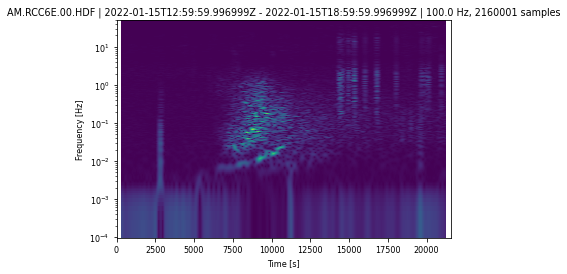

In [126]:
worfile = os.path.join(SEISAN_TOP, 'WOR', '2022-01-15-1300-00S.Tonga_038')
st = obspy.read(worfile)
st = st.select(channel='HDF')
st2 = st.copy()
for tr in st2:
    fh = plt.figure(figsize=(16,16))
    tr.data = tr.data / 56000
    tr.plot(handle=fh);

    #tr.plot(type='dayplot')
    tr.spectrogram(log=True, wlen=500, per_lap=0.95)

In [51]:
# Execute array_processing - might want to decimate first, based on frqhigh
st2 = st.copy()
#st2.remove(st2[2])

def medfilt(x, k):
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    assert k % 2 == 1, "Median filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros ((len (x), k), dtype=x.dtype)
    y[:,k2] = x
    for i in range (k2):
        j = k2 - i
        y[j:,i] = x[:-j]
        y[:j,i] = x[0]
        y[:-j,-(i+1)] = x[j:]
        y[-j:,-(i+1)] = x[-1]
    return np.median(y, axis=1)

st2.detrend()
winlen_secs = 10.0
for tr in st2:
    winlen = int(np.round(winlen_secs/tr.stats.delta, 0))
    if winlen % 2 == 0:
        winlen += 1
    tr.data = medfilt(np.abs(tr.data), winlen)
    
#st2.filter('bandpass', freqmin=0.1, freqmax=0.5, corners=3)
st2.decimate(4)

3 Trace(s) in Stream:
AM.R095E.00.HDF | 2022-01-15T14:09:21.504999Z - 2022-01-15T17:09:21.504999Z | 12.5 Hz, 135001 samples
AM.R17FC.00.HDF | 2022-01-15T14:09:21.498999Z - 2022-01-15T17:09:21.498999Z | 12.5 Hz, 135001 samples
AM.RCC6E.00.HDF | 2022-01-15T14:09:21.496999Z - 2022-01-15T17:09:21.496999Z | 12.5 Hz, 135001 samples

In [ ]:
#st2 = st.copy()
#st2.decimate(8)
stime=obspy.UTCDateTime(2022,1,15,14,15,0)
etime=obspy.UTCDateTime(2022,1,15,16,45,0)
max_slowness = 3.0

kwargs = dict(
    # slowness grid: X min, X max, Y min, Y max, 
    sll_x=-max_slowness, slm_x=max_slowness, sll_y=-max_slowness, slm_y=max_slowness, sl_s=0.03,
    # sliding window properties
    # win_len=1.0, win_frac=0.05, for local building collapse
    win_len=300.0, win_frac=0.1, 
    # frequency properties
    #frqlow=0.05, frqhigh=2.0, prewhiten=0,
    frqlow=0.02, frqhigh=1.0, prewhiten=0,
    # restrict output
    semb_thres=-1e9, vel_thres=-1e9,    
    stime=stime, 
    etime=etime
)

print('Starting array processing')
out = array_processing(st2, **kwargs)
print('Array processing complete')

# Plot

cmap = obspy_sequential

# make output human readable, adjust backazimuth to values between 0 and 360
t, rel_power, abs_power, baz, slow = out.T
baz[baz < 0.0] += 360



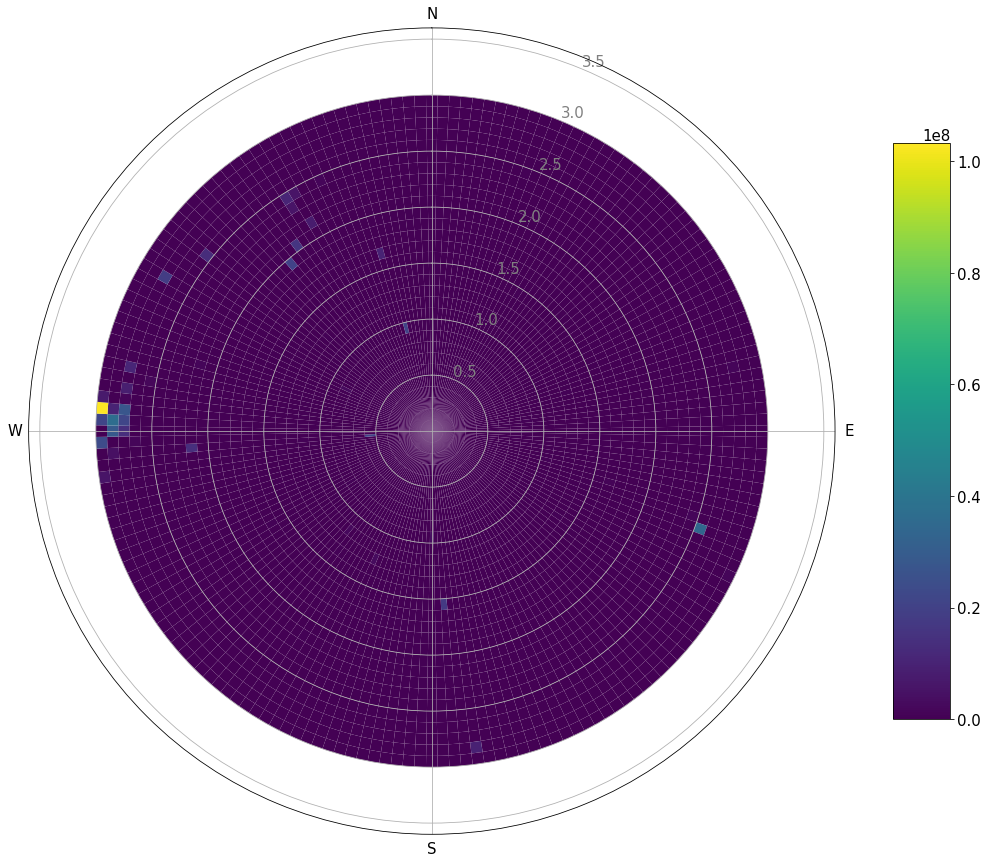

In [136]:
# choose number of fractions in plot (desirably 360 degree/N is an integer!)
# defaults 36, 30
N = 180
N2 = 30 
abins = np.arange(N + 1) * 360. / N # azimuth bins
sbins = np.linspace(0, 3, N2 + 1) # slowness bins

# sum rel power in bins given by abins and sbins
hist, baz_edges, sl_edges = \
    np.histogram2d(baz, slow, bins=[abins, sbins], weights=abs_power) # default is rel power

# transform to radian
baz_edges = np.radians(baz_edges)

# add polar and colorbar axes
fig = plt.figure(figsize=(16,16))
plt.rc('font', size=15)
cax = fig.add_axes([0.85, 0.2, 0.05, 0.5])
ax = fig.add_axes([0.10, 0.1, 0.70, 0.7], polar=True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")

dh = abs(sl_edges[1] - sl_edges[0])
dw = abs(baz_edges[1] - baz_edges[0])

# circle through backazimuth
for i, row in enumerate(hist):
    bars = ax.bar(x=(i * dw) * np.ones(N2),
                  height=dh * np.ones(N2),
                  width=dw, bottom=dh * np.arange(N2),
                  color=cmap(row / hist.max()))

ax.set_xticks(np.linspace(0, 2 * np.pi, 4, endpoint=False))
ax.set_xticklabels(['N', 'E', 'S', 'W'])

# set slowness limits
ax.set_ylim(0, max_slowness)
[i.set_color('grey') for i in ax.get_yticklabels()]
ColorbarBase(cax, cmap=cmap,
             norm=Normalize(vmin=hist.min(), vmax=hist.max()))

plt.show()

In [17]:
from obspy.geodetics import gps2dist_azimuth
s, az, backaz = gps2dist_azimuth(vlat, vlon, st[0].stats.coordinates.latitude, st[0].stats.coordinates.longitude)
print(s, az, backaz)

11463641.881794268 67.04869552090548 253.41547933241037


In [137]:
np.arccos(2.75/3.0)*180/3.14159

23.556484206412232

In [138]:
np.arccos(2.95/3.0)*180/3.14159

10.47532269135597

In [140]:
1/2.95

0.3389830508474576

Starting array processing
Array processing complete


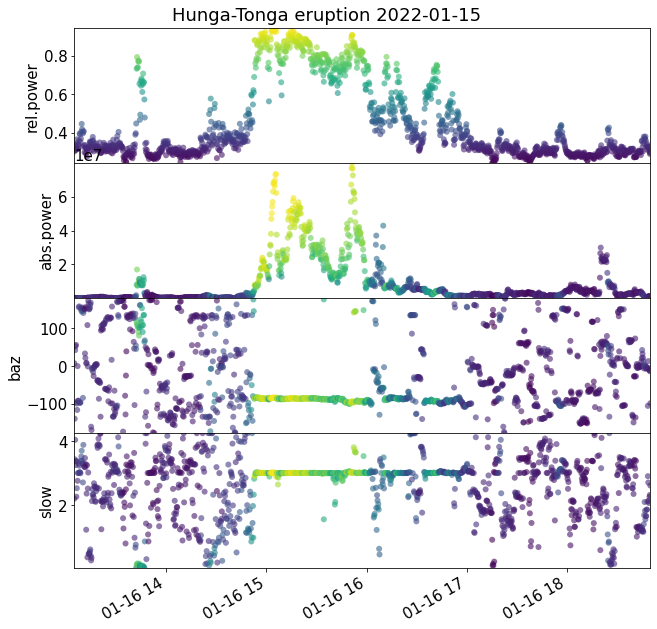

In [135]:
# Execute array_processing
#st2 = st.copy()
#st2.remove(st2[2])
#st2.filter('bandpass', freqmin=0.1, freqmax=0.5, corners=3)
#st2.decimate(8)

stime=obspy.UTCDateTime(2022,1,15,13,5,0)
etime=obspy.UTCDateTime(2022,1,15,18,55,0)

kwargs = dict(
    # slowness grid: X min, X max, Y min, Y max, Slow Step
    sll_x=-3.0, slm_x=3.0, sll_y=-3.0, slm_y=3.0, sl_s=0.03,
    # sliding window properties
    #win_len=300.0, win_frac=0.1,
    win_len=300.0, win_frac=0.05,
    # frequency properties
    #frqlow=0.1, frqhigh=1.0, prewhiten=0,
    frqlow=0.02, frqhigh=1.0, prewhiten=0,
    # restrict output
    semb_thres=0.1, vel_thres=0.1, timestamp='mlabday',
    stime=stime, 
    etime=etime
)

print('Starting array processing')
out = array_processing(st2, **kwargs)
print('Array processing complete')

# Plot
labels = ['rel.power', 'abs.power', 'baz', 'slow']

xlocator = mdates.AutoDateLocator()
fig = plt.figure(figsize=(10,10))
for i, lab in enumerate(labels):
    ax = fig.add_subplot(4, 1, i + 1)
    ax.scatter(out[:, 0], out[:, i + 1], c=out[:, 1], alpha=0.6,
               edgecolors='none', cmap=obspy_sequential)
    ax.set_ylabel(lab)
    ax.set_xlim(out[0, 0], out[-1, 0])
    ax.set_ylim(out[:, i + 1].min(), out[:, i + 1].max())
    ax.xaxis.set_major_locator(xlocator)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(xlocator))

fig.suptitle('Hunga-Tonga eruption %s' % (
    stime.strftime('%Y-%m-%d'), ))
fig.autofmt_xdate()
fig.subplots_adjust(left=0.15, top=0.95, right=0.95, bottom=0.2, hspace=0)
plt.show()

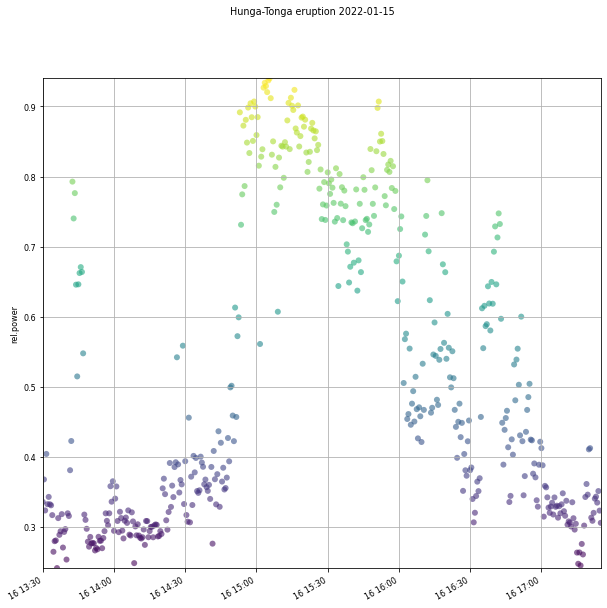

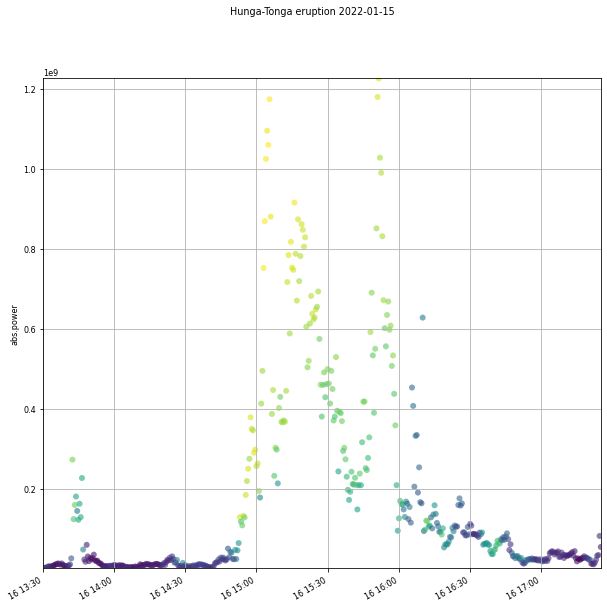

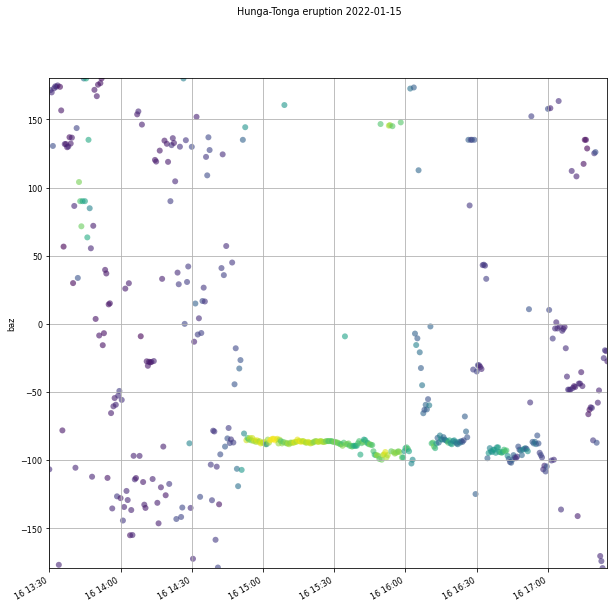

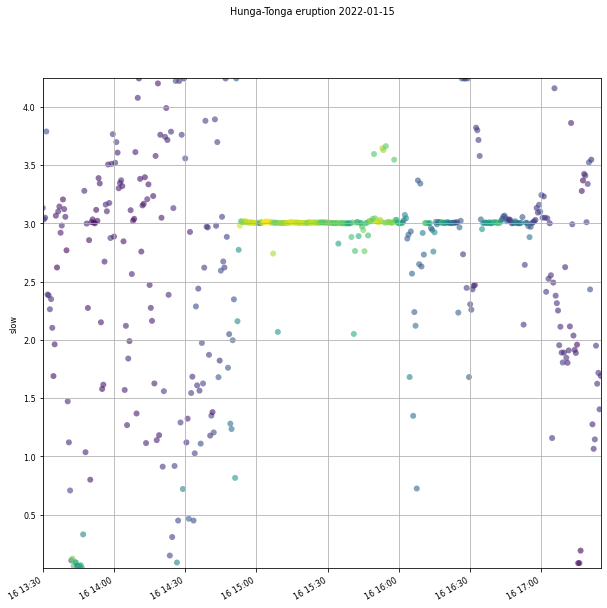

In [101]:
labels = ['rel.power', 'abs.power', 'baz', 'slow']
xlocator = mdates.AutoDateLocator()
for i, lab in enumerate(labels):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(out[:, 0], out[:, i + 1], c=out[:, 1], alpha=0.6,
               edgecolors='none', cmap=obspy_sequential)
    ax.set_ylabel(lab)
    ax.set_xlim(out[0, 0], out[-1, 0])
    ax.set_ylim(out[:, i + 1].min(), out[:, i + 1].max())
    ax.xaxis.set_major_locator(xlocator)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(xlocator))
    ax.grid()

    fig.suptitle('Hunga-Tonga eruption %s' % (
        stime.strftime('%Y-%m-%d'), ))
    fig.autofmt_xdate()
    plt.show()